<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/ComputerVision/03_OpenCV_Image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# helper function
def read_image(img_name):
  img = cv2.imread(img_name)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return rgb_img

Text(0.5, 1.0, 'Train Image')

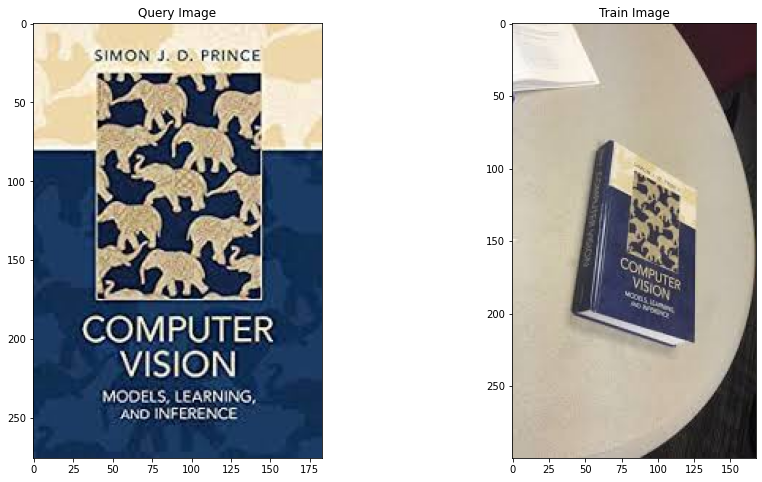

In [6]:
query_img = './book_image.jpeg'
train_img = './book_on_table.jpeg'

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(read_image(query_img))
plt.title('Query Image')

plt.subplot(1,2,2)
plt.imshow(read_image(train_img))
plt.title('Train Image')

In [7]:
img1 = cv2.imread(query_img, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(train_img, cv2.IMREAD_GRAYSCALE)

## ORB detector
> ORB (Oriented FAST and rotated BRIEF)

image로부터 feature를 얻는 다양한 알고리즘 중 하나로, 연산량은 낮으면서 성능은 우수한 알고리즘이다.

o-FAST keypoint detector와 r-BRIEF descriptor가 합쳐진 형태이다.


### FAST keypoint detector

FAST는 영상에서 실시간으로 keypoint를 찾아내는 알고리즘으로, 하나의 keypoint에 여러 개의 feature를 가지는 SIFT와는 달리 하나의 keypoint에 하나의 feature만을 가진다. FAST의 핵심은 중심 픽셀과 그 주변의 원형 내에 위치한 픽셀들과의 차이를 구분한다는 것이다. 이때 FAST는 자체적으로 corner를 만들어내지 않기에 Harris corner 방식으로 얻어진 keypoint를 사용하며, N개의 keypoint를 얻기 위해 임계값을 일부러 낮게 설정한 뒤 상위 N개의 keypoint만을 추출해 사용한다. 또한 multi-scale 기능도 지원하지 않아 scale pyramid 방식으로 각각의 단계마다 FAST feature를 생성한다.

이때 FAST에는 방향에 대한 계산이 들어가지 않아 방향에 대한 detection을 지원하지 않는다는 단점을 가졌다. 이에 intensity centroid 방법을 사용해 방향성을 얻고자 한다. 조금 더 구체적으로 설명하자면 위의 방식을 통해 구해진 코너는 중심의 픽셀값과 차이를 보이기에 중심으로부터 코너까지의 벡터는 해당 keypoint의 방향성을 설명할 수 있다는 것이다.

​
이렇게 기존에 존재하던 FAST keypoint detector에 방향성을 더한 o-FAST keypoint detector가 개발되었다.

### BRIEF descriptor

SIFT의 연산 속도가 느린 이유는 SIFT 알고리즘이 128차원이라는 높은 차원의 벡터를 가지고 있기 때문이다. 이를 개선하기 위해 SURF가 개발되었지만, 눈에 띄는 용량의 감소는 아니었다. 이는 descriptor 자체가 많은 비트를 가지고 있어야 했기 때문이다. 따라서 이에 대한 대안으로 나온 것이 descriptor를 이진화(binarize)하는 방식이었고, 이렇게 나온 알고리즘이 BRIEF descriptor이다.


이렇게 만들어진 BRIEF descriptor는 시점, 조명, 블러에 강인한 모습을 보였다. 그러나 BRIEF descriptor는 이미지가 조금만 회전하더라도 성능이 확연하게 저하되는 단점이 있었다. 이에 모든 각도와 원근 변화를 연산하는 알고리즘도 개발되었지만, 효율이 그리 좋지 못했다. 따라서 각도를 12도로 고정한 상태로 모든 BRIEF 패턴을 계산해 계산 속도를 빠르게 하는 Steered BRIEF 방식이 개발되었으며, ORB에서는 r-BRIEF라는 이름으로 적용되었다.

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ghd3079&logNo=221496302601

In [8]:
# initiate ORB detector
orb = cv2.ORB_create()

In [13]:
# find the keypoint and descriptors
kp1, des1 = orb.detectAndCompute(img1, None) # orb.detectAndCompute(입력이미지, 마스크)
kp2, des2 = orb.detectAndCompute(img2, None)

In [18]:
kp1[:10]

(< cv2.KeyPoint 0x7fbf28e99540>,
 < cv2.KeyPoint 0x7fbf28e6bf90>,
 < cv2.KeyPoint 0x7fbf1eae5c30>,
 < cv2.KeyPoint 0x7fbf1eae58a0>,
 < cv2.KeyPoint 0x7fbf1eae5420>,
 < cv2.KeyPoint 0x7fbf1eae5e70>,
 < cv2.KeyPoint 0x7fbf1eaf6ea0>,
 < cv2.KeyPoint 0x7fbf1eaf6960>,
 < cv2.KeyPoint 0x7fbf1eaf6900>,
 < cv2.KeyPoint 0x7fbf1eaf6f60>)

In [15]:
des1

array([[246,  78, 111, ...,  51, 119, 160],
       [ 34, 191, 122, ...,  10, 124, 139],
       [ 48, 175,  82, ...,   8, 116, 138],
       ...,
       [232,  52, 189, ...,  75, 151, 243],
       [  3, 246,  35, ..., 213,  35, 253],
       [ 43, 214,  15, ..., 212, 170, 217]], dtype=uint8)

In [16]:
# create Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # Hamming Distance: 0과 1로 이루어진 descriptor

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

In [19]:
matches[:10]

[< cv2.DMatch 0x7fbf1e1e71f0>,
 < cv2.DMatch 0x7fbf28efd270>,
 < cv2.DMatch 0x7fbf1eacc910>,
 < cv2.DMatch 0x7fbf1eaccf50>,
 < cv2.DMatch 0x7fbf1f284970>,
 < cv2.DMatch 0x7fbf1e1e75f0>,
 < cv2.DMatch 0x7fbf1e1e78d0>,
 < cv2.DMatch 0x7fbf1e1e7910>,
 < cv2.DMatch 0x7fbf1e1e7c30>,
 < cv2.DMatch 0x7fbf1eacdb90>]

In [21]:
# Draw first 10 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, \
                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [26]:
img3

array([[[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [ 35,  35,  35],
        [ 35,  35,  35],
        [ 35,  35,  35]],

       [[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [ 35,  35,  35],
        [ 35,  35,  35],
        [ 35,  35,  35]],

       [[237, 237, 237],
        [237, 237, 237],
        [237, 237, 237],
        ...,
        [ 35,  35,  35],
        [ 35,  35,  35],
        [ 35,  35,  35]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 17,  17,  17],
        [ 12,  12,  12],
        [  9,   9,   9]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 18,  18,  18],
        [ 14,  14,  14],
        [ 11,  11,  11]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 19,  19,  19],
        [ 15,  15,  15],
        [ 13,  13,  13]]

Text(0.5, 1.0, 'Image Matching')

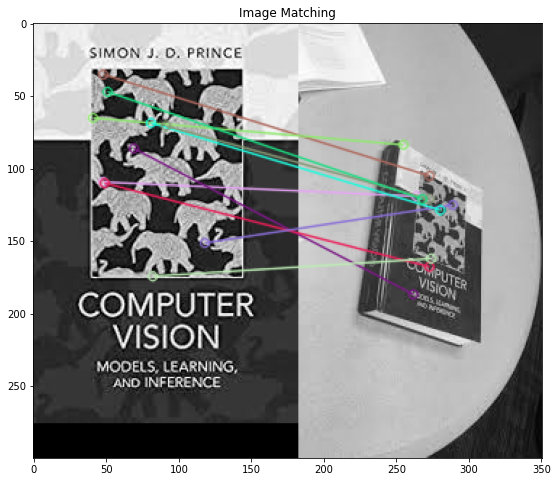

In [27]:
plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.title('Image Matching')

### +) BF Matching with SIFT Descriptors and Ratio Test

In [29]:
# initiate SIFT
sift = cv2.SIFT_create()

# find kp and des
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFMatcher with default params (L2 distance)
bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k=2)

# Apply Ratio Test
point = []
for m,n in matches:
  if m.distance < n.distance * 0.75:
    point.append([m])

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, point, None,\
                          flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

Text(0.5, 1.0, 'Image Matching with SIFT')

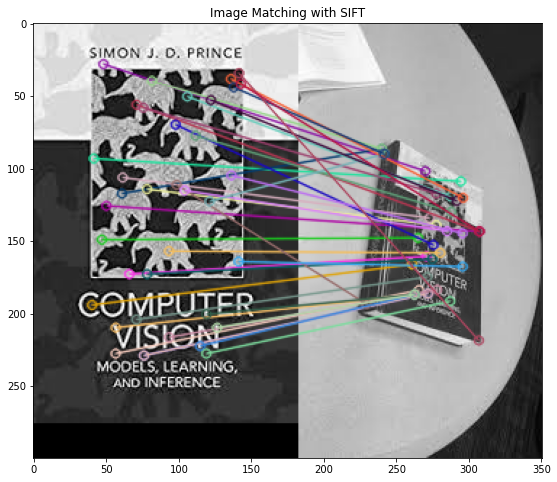

In [30]:
plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.title('Image Matching with SIFT')